# Medical Cost Prediction using Linear Regression

**Sorce of dataset:** https://www.kaggle.com/datasets/mirichoi0218/insurance/data

**Introduction:**
This dataset lists the costs for treatments of 1338 patients in the United States. There is no information given, which diagnosis is present. With the given data features it may be possible to make conculusions on the patients health.
It may also be possible to predict the medical costs, by building up a linear regression model.


### Questions of interest

1. Which factors contribute the most reagring medical costs?
2. Can anything be said about the state of health of the residents from the data for the individual regions?
3. Is it possible to predict health insurance costs from the given features?

In [1]:
# import libaries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# read the .csv input data as dataframe (df). Make a copy of the df to allow changing categorical values.

df = pd.read_csv("..\data\insurance.csv")
df_original = df.copy()

In [3]:
# have a look on the first 5 lines of the dataframe

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
# print information about data types, columns, null value counts, etc.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# print descripitive statistics 

df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


**Insights from descriptive statistics of the dataset**

    
    Age:               Between 18 to 64 year old. Values seems to be realistic.
    BMI:               Between 15.96 to 53.13. Values seems to be realistic.
    Children:          Between 0 to 5 children. Values seems to be realistic.
    Charges:           Between 1.1k to 16.6k. Values seems to be realistic.

In [6]:
# find null values in dataframe

print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


As we intend to use a linear regression model, it is important that no NaN values are present in the data.

**Check for duplicate entries**

In [7]:
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [8]:
# only one row is duplicated. Drop this row
df.drop_duplicates(inplace=True)

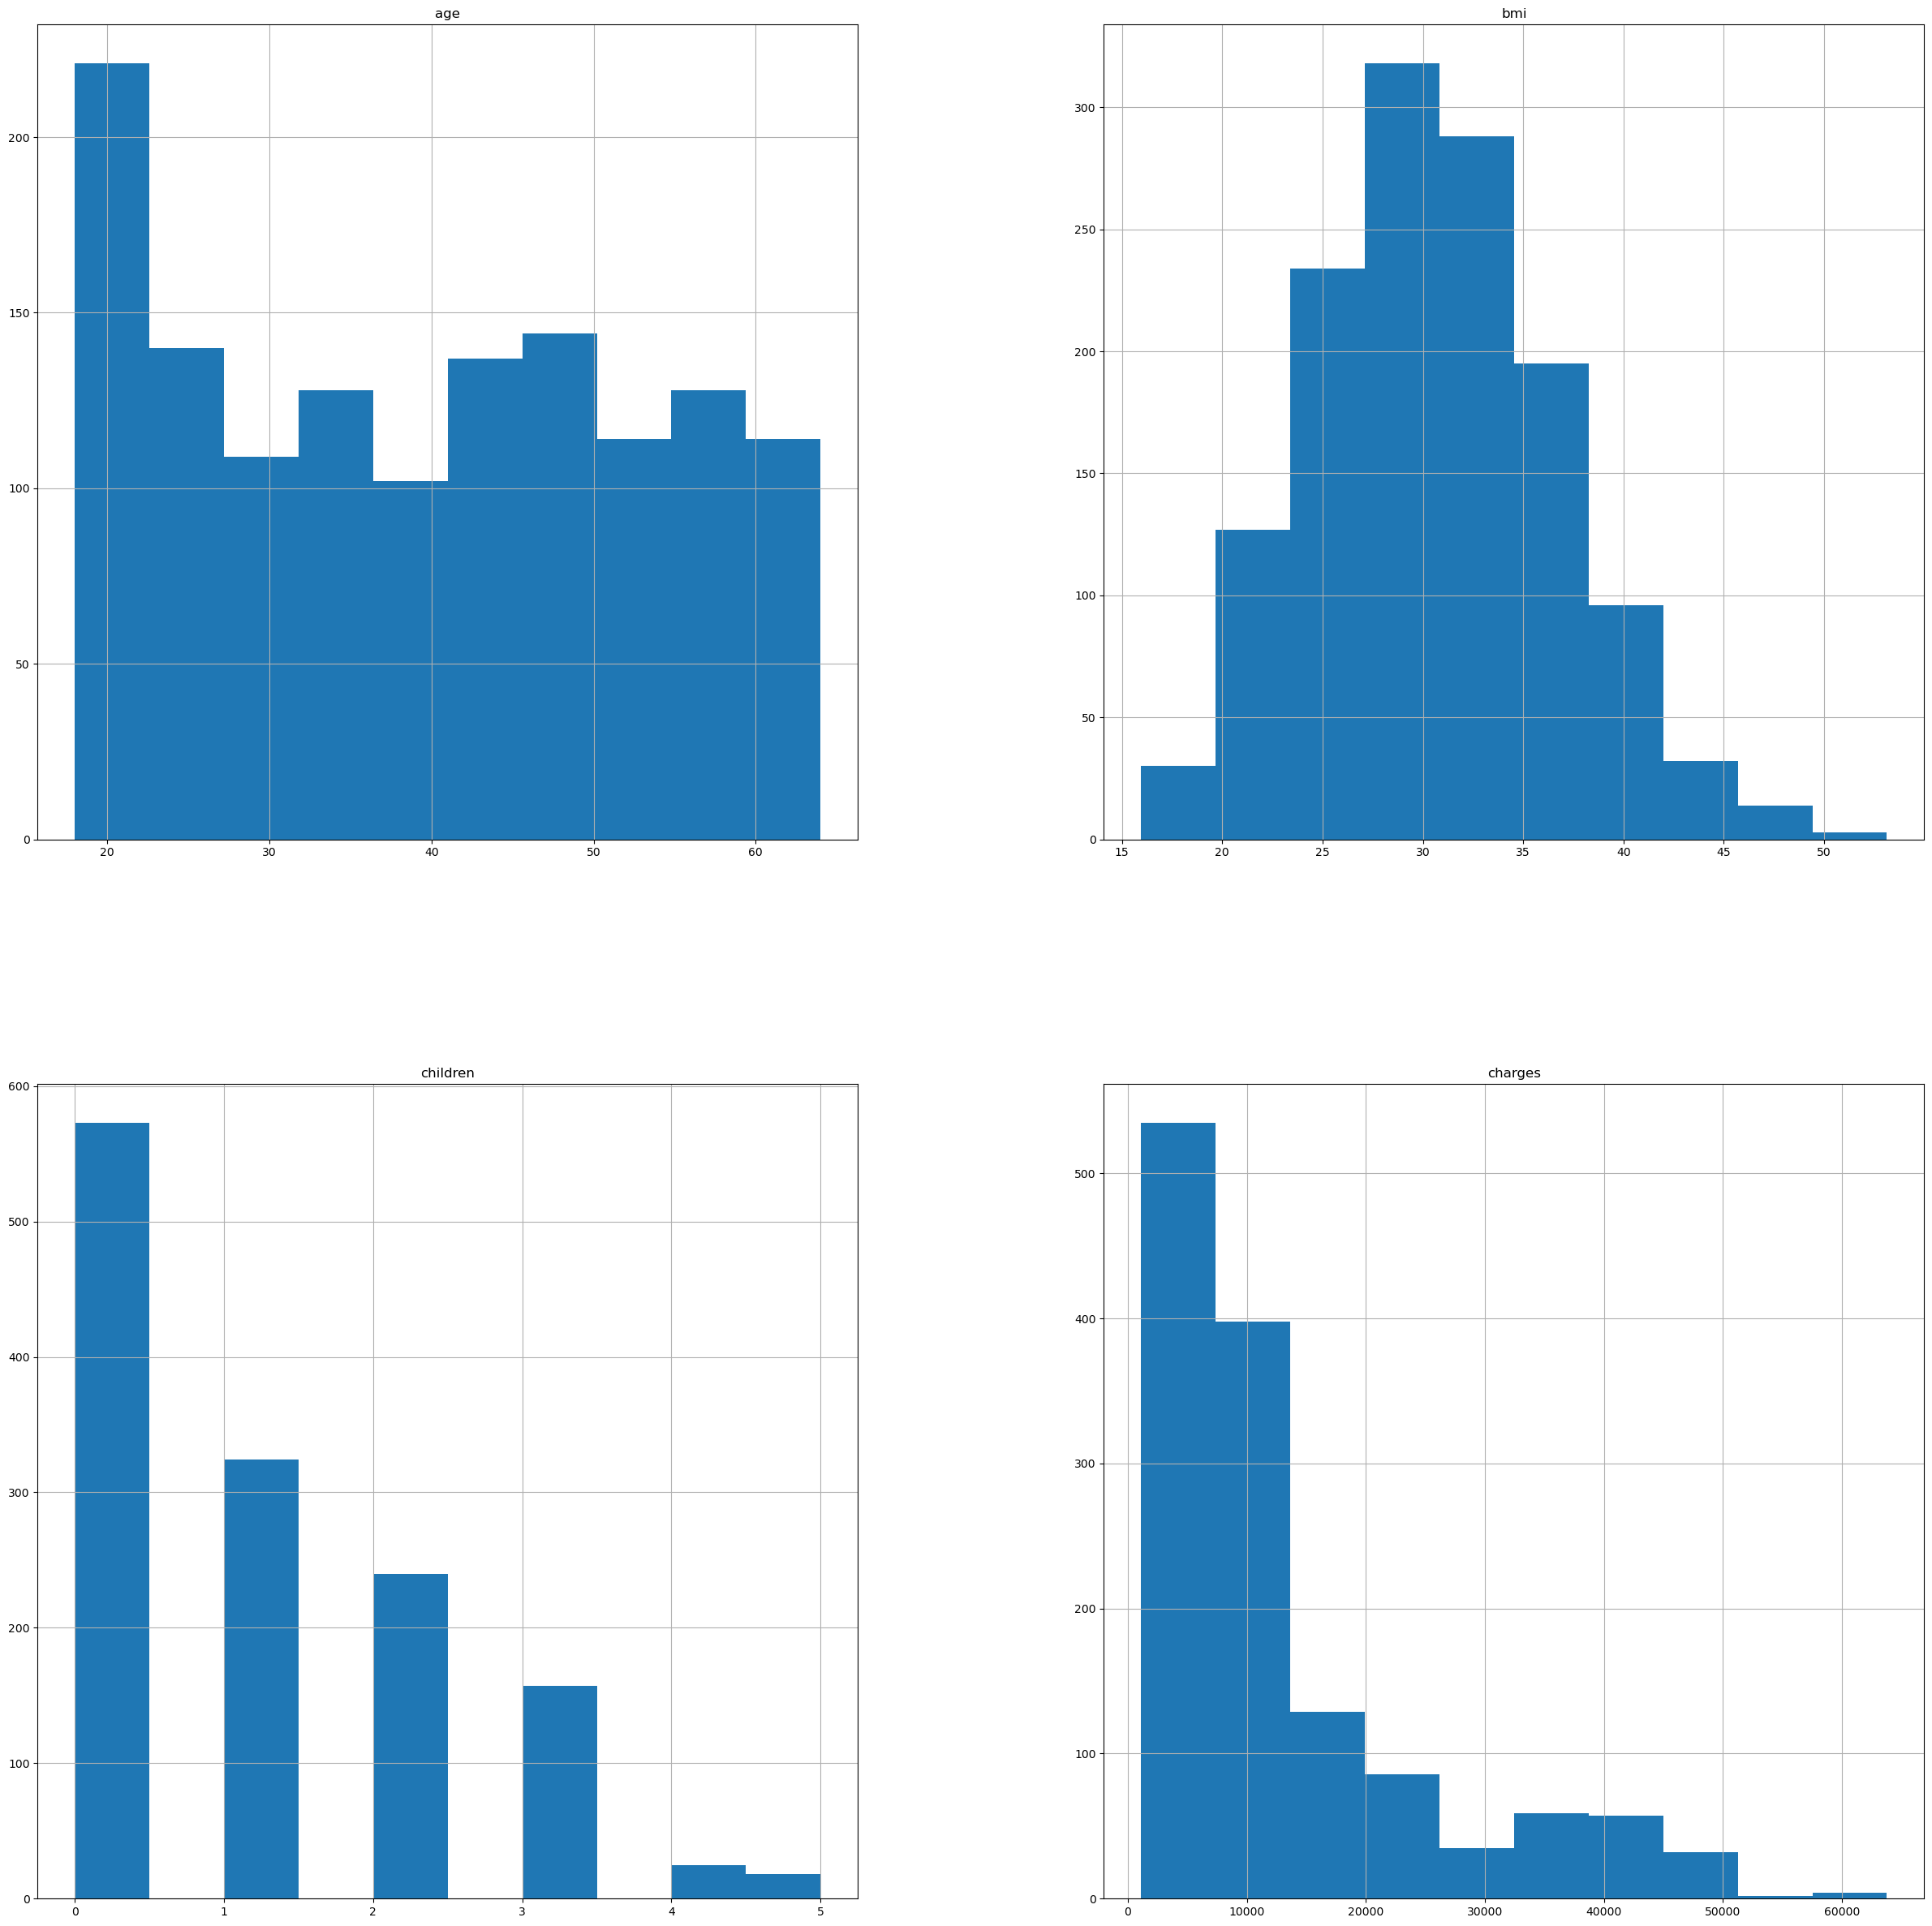

In [9]:
# visualize the distribution

# show the distribution of the data in histograms
p = df.hist(figsize=(30,30))

Distibution on data features:
- Age
- BMI
- Children
- Charges

looks ok, which means no outliers apparent

### **Question 1:** Which factors contribute the most reagring insurance costs?

To get the dependency of the data features, we need to compute the correlation of columns.
Using **pandas.DataFrame.corr** could be an option. One precondition is to convert the categorical variables:
- Sex
- Region
- Smoker

In [10]:
# replace values in categorical columns

sex_mapping = {'male': 0, 'female': 1}
smoker_mapping = {'no': 0, 'yes': 1}
region_mapping = {'northeast': 0, 'northwest': 1, "southeast": 2, "southwest": 3}

df['sex'] = df['sex'].map(sex_mapping)
df['smoker'] = df['smoker'].map(smoker_mapping)
df['region'] = df['region'].map(region_mapping)

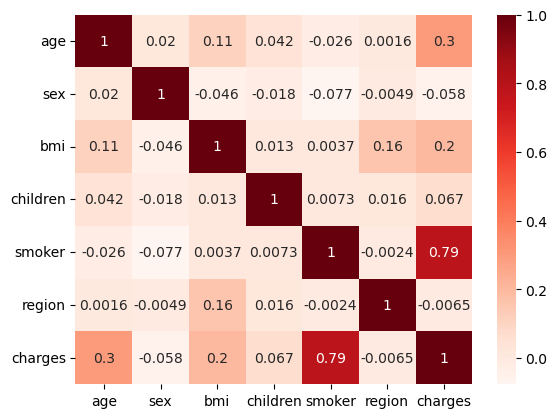

In [11]:
sns.heatmap(df.corr(), annot=True,cmap ='Reds');

***Result Question 1:***
The top three factors which contribute the most to the high of the medical costs are:
- Smoker
- Age
- BMI

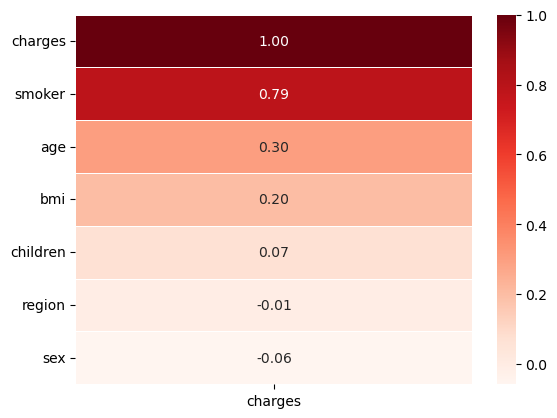

In [12]:
# get a visualization which is better suited for the blog post

outcome_corr = df.corr()['charges'].sort_values(ascending=False)
sns.heatmap(pd.DataFrame(outcome_corr), annot=True, cmap='Reds', fmt=".2f", linewidths=.7);

### **Question 2:** Can anything be said about the state of health of the residents from the data for the individual regions?

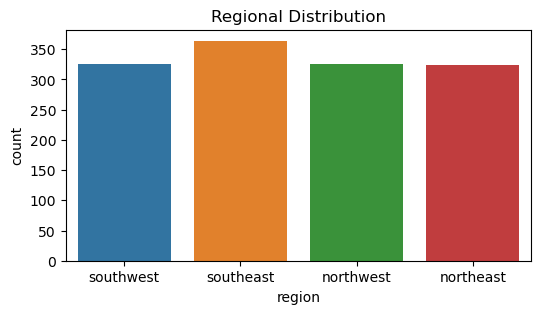

In [13]:
# Have a look on the regional distribution

plt.figure(figsize=(6, 3))
plt.title("Regional Distribution")
sns.countplot(x='region', data=df_original);

In [14]:
# Have a look on the gender distribution 

df_original.groupby(['region', 'sex']).size().unstack(fill_value=0)

sex,female,male
region,,
northeast,161,163
northwest,164,161
southeast,175,189
southwest,162,163


The gender distribution by region is almost equal, except for 'southeast' region. There are more male in the dataset than female. Men may have a tendency to have higer medical costs, which could lead to a slight distortion, as can be seen in the above barplot.
Have a look to check if this is true.

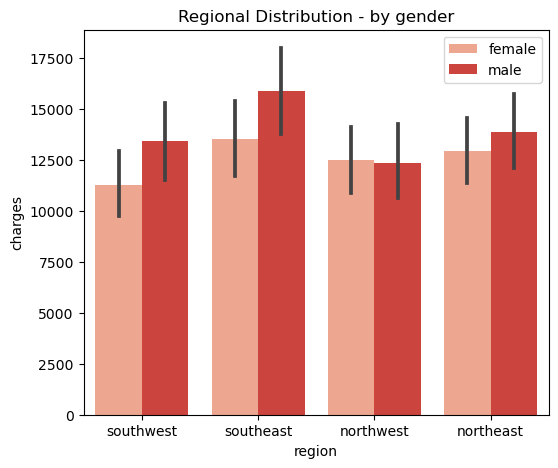

In [15]:
plt.figure(figsize=(6, 5))
plt.title("Regional Distribution - by gender")
sns.barplot(x='region', y='charges', hue='sex', data=df_original, palette='Reds');
plt.legend(loc="upper right");

As shown in the barplot above, male patients tend to have higher medical costs than female patients. 

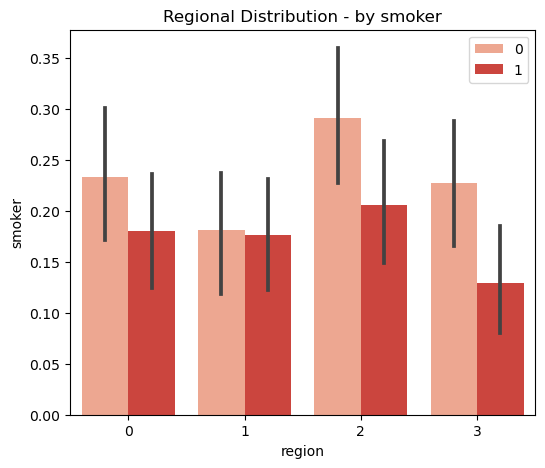

In [16]:
# 0=Female, 1=Male
#'northeast': 0, 'northwest': 1, "southeast": 2, "southwest": 3
plt.figure(figsize=(6, 5))
plt.title("Regional Distribution - by smoker")
sns.barplot(x='region', y='smoker', hue='sex', data=df, palette='Reds');
plt.legend(loc="upper right");

Female smoke more in each region

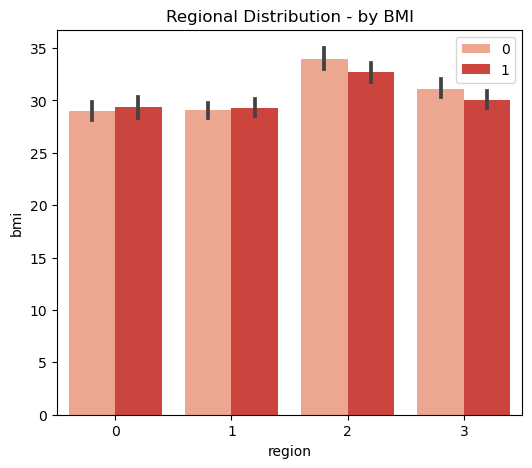

In [17]:
# 0=Female, 1=Male
#'northeast': 0, 'northwest': 1, "southeast": 2, "southwest": 3
plt.figure(figsize=(6, 5))
plt.title("Regional Distribution - by BMI")
sns.barplot(x='region', y='bmi', hue='sex', data=df, palette='Reds');
plt.legend(loc="upper right");

In [18]:
df_original.groupby('region')['charges'].mean()

region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64

In [19]:
# 'northeast': 0, 'northwest': 1, "southeast": 2, "southwest": 3
df.groupby('region')['smoker'].sum()

region
0    67
1    58
2    91
3    58
Name: smoker, dtype: int64

In [20]:
# check the percentage of smokers

result = df.groupby('region').agg({
    'smoker': ['sum', 'count']
})

result.columns = ['smokers', 'total']
result['percentage'] = (result['smokers'] / result['total']) * 100

# Reset index to make 'region' a column again
result = result.reset_index()

# Sort by percentage in descending order
result = result.sort_values('percentage', ascending=False)
print(result)

   region  smokers  total  percentage
2       2       91    364   25.000000
0       0       67    324   20.679012
1       1       58    324   17.901235
3       3       58    325   17.846154


In [21]:
# check the mean bmi
# 'northeast': 0, 'northwest': 1, "southeast": 2, "southwest": 3
df.groupby('region')['bmi'].mean()

region
0    29.173503
1    29.195494
2    33.355989
3    30.596615
Name: bmi, dtype: float64

In [22]:
# check the mean age
# 'northeast': 0, 'northwest': 1, "southeast": 2, "southwest": 3
df.groupby('region')['age'].mean()

region
0    39.268519
1    39.259259
2    38.939560
3    39.455385
Name: age, dtype: float64

Mean ages do not differ strongly in the regions

C:\Users\dsimons\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\dsimons\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\dsimons\AppData\Local\Temp\ipykernel_22900\2156110705.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


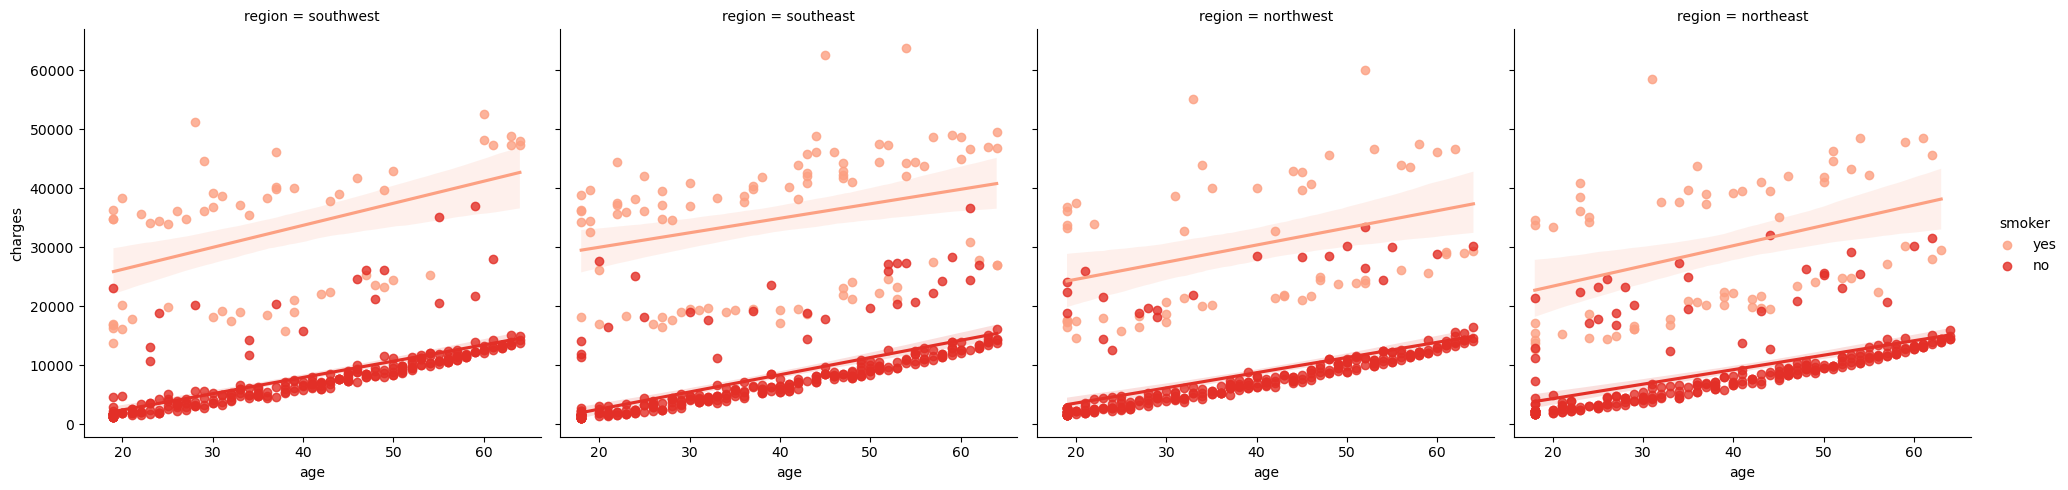

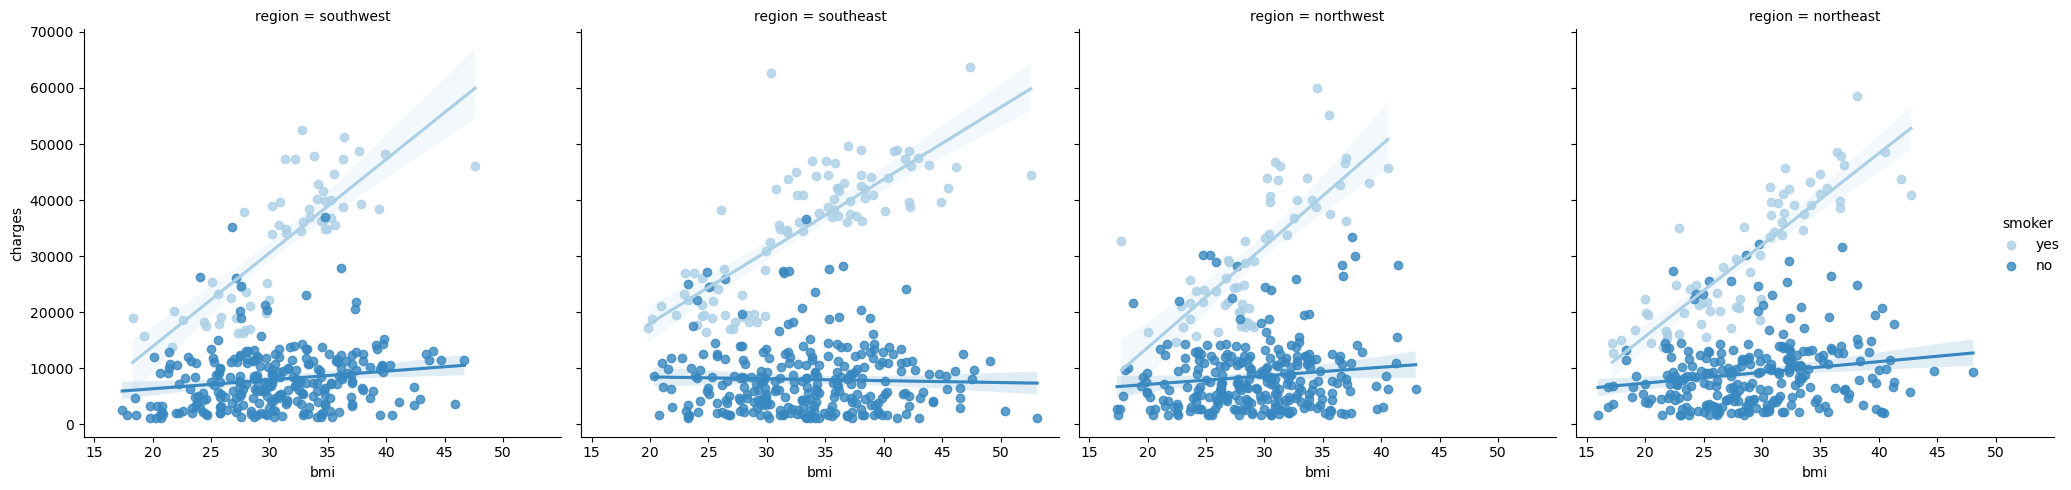

In [23]:
# Check for the three most important factors which contribute the most to the height of the medical costs (see Question 1):
# -> Smoker, Age, BMI

sns.lmplot(x = 'age', y = 'charges', data=df_original, col="region", hue='smoker', palette='Reds')
sns.lmplot(x = 'bmi', y = 'charges', data=df_original, col="region", hue='smoker', palette='Blues')
plt.tight_layout()

*Insights from the calculations*:

As expected, medical costs are rising with age, BMI and if you are a smoker.
It can be seen that in the region 'southeast', people smoke more and have also highest mean BMI compared to the other regions.


Nevertheless, the data shows also that there are single individuals which influence stronly the costs for a region.

###  Question 3: Is it possible to predict health insurance costs from the given features?

***Let's use a linear regression model to try predicting medical costs***

In [24]:
# define X matrix and response vector
X = df.drop(['charges', 'region'], axis=1)
y = df.charges


# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

# init linear regression model
lr_model = LinearRegression() 

# fit the model and obtain pred response
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_test)

print(lr_model.score(X_test, y_test))

0.804621881177266


Model prediction performs good at the medical costs of patients., with R² of 0.8